In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 7us/step


보스턴 주택 데이터셋 로드하기

In [3]:
train_data.shape


(404, 13)

In [4]:
test_data.shape

(102, 13)

404개의 훈련샘플, 102개의 테스트 샘플이 있다.

In [5]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

가격은 일반적으로 1만달러 ~ 5만달러 사이이다

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

<h2> 데이터 준비
    <h2> 데이터 정규화 하기
        <h3>입력 데이터에 있는 각 특성(입력 데이터 행렬의 열)에 대해서 특성의 평균을 빼고 표준편차로 나눕니다. 
            <h3>특성의 중앙이 0근처에 맞추어 지고 표준편차가 1이 됩니다.

In [18]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu'
                           , input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model
    

<h2>모델 구성
    <h3> input -> Dense(units = 64) -> Dense(units = 64) -> Dense(units = 1) -> output
        <h3> 앞의 예제와는 다르게, 마지막 출력층이 활성함수가 아니다.
            <h3> 마지막층이 순수한 선형이므로 네트워크가 어떤 범위의 값이라도 예측하도록 자유롭게 학습된다.
                <h3> optimizer : rmsprop, loss : mse, metrics : mae
                    <h3> mse(mean squared error) 예측과 타깃 사이거리의 제곱 
                        <h3> mae(mean absolute error) :  예측과 타깃 사이의 절댓값

In [19]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


<h2> k-겹을 사용한 훈련검증
    <h3> 데이터를 k개의 분할로 나누고, k개의 모델을 각각 만들어 k-1개의 분할에서 훈련하고 나머지 분할에서 평가하는 방법이다.
        <h3> 훈련세트와 검증세트가 적기때문에, 검증세트의 분할에 대한 검증 점수의 분산이 높다. -> 신뢰있는 모델 평가 X

In [20]:
all_scores

[1.8270535374631975,
 2.2850802511271864,
 2.9333208197414287,
 2.3919291921181256]

In [21]:
np.mean(all_scores)

2.3593459501124845

In [22]:
from keras import backend as K

K.clear_session()

In [24]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i+1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i+1) * num_val_samples:]],
        axis=0
    )
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                       validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


<h2> 각 폴드에서 검증 점수를 로그에 저장하기
    <h3> 500 에포크 동안 훈련, 검증 점수를 로그에 저장.

In [25]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]


In [26]:
import matplotlib.pyplot as plt

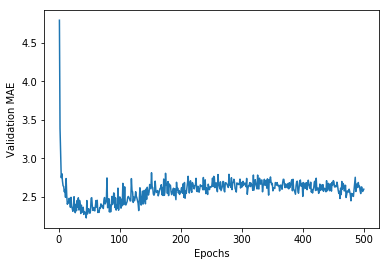

In [27]:
plt.plot(range(1, len(average_mae_history) + 1),average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

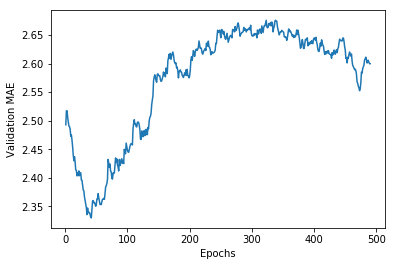

In [32]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()
    
    
    

첫번째로 만든 그래프는 범위가 크고 변동이 심하여 가시성이 떨어진다. => 지수 이동 평균으로 대체
검증 MAE가 80번째 에포크 이후에 줄어드는 것이 멈추었다. 이지점 이후로는 과대적합이 시작된다.

In [33]:
model = build_model()

model.fit(train_data, train_targets,
         epochs=80, batch_size=16, verbose =0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 2ms/step


In [34]:
test_mae_score

2.685365265490962

아직 2680달러 정도 차이가 난다.